# Problem Statement

Whether one trades in Stocks, Index, Currencies, Commodities, a person would like to know questions like:

- What is the market trend? Will it continue?
- Whether market will close higher or lower compared to its opening levels? 
- What could be expected high, low, close levels?

There could be many more such questions. The first challenge is to know the trend and direction of the market. If there was a crystal ball that could provide meaningful prediction in advance on the trend and direction of the markets that could help take correct trading position to make profitable trades.
Predictive analytics based on historical price data using supervised machine learning approach can provide prediction in advance on whether the next day market will close higher or lower compared to its opening levels.  

We chose to investigate whether there is a connection between the sentiment in the news for a given day and the resulting market value changes for Apple, Inc on the same day. Particularly, we treated this as a supervised machine learning approach and discrete classification problem where stock price either went down or up.

# Data Munging and Feature Extraction

- As stated, we limited our scope to examine the news related to tech giant Apple. We scaped the Motley Fool site for a three year's worth of relevant news articles based on searches by the company name.


- Afterwards, we used the Sentiment Lexicon, a dictionary of positive/negative words released by the University of Pittsburgh described in this [paper]("http://people.cs.pitt.edu/~wiebe/pubs/papers/emnlp05polarity.pdf") and that can be downloaded [here]("http://mpqa.cs.pitt.edu"), to count the sentiment score for each article. A negative word received a "-1" score, whereas positive word scored "+1". If a word is not found the dictionary, its score is zero.


- For the historical Apple stock prices, we used "go-to" Quandl website and their API. We calculated the difference between **opening** and **closing** prices to get the returns. If a return is negative and less than -0.001, then we classified it as **-1**. If a return is between **-0.001 and 0.001**, we classified it as **0**. Finally, if a return is greater than **0.001**, we classified it as **1**. This **"diff"** columns constituted the label.


- In the next step, we merged two data sets based on the date. For the final version of the data set, we chose only the **sentiment score** as a feature and **diff** as a label to train all our models.





**Note**: we commented out lines of codes where the scraping part is done. The scrapped data is available in github repo with name *"mfool.csv"*.

In [15]:
#data munging and feature extraction packages
import requests
import requests_ftp
import requests_cache
import lxml
import itertools
import pandas as pd
import re
import numpy as np
import seaborn as sns
import string
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 8]

#machine learning from scikit-learn
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_curve, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Deep learning from Tensor Flow
#feed forward neural network
import tensorflow as tf
from  tensorflow.contrib.learn.python.learn.estimators.dnn  import DNNClassifier
from tensorflow.contrib.layers import real_valued_column

#recurrent neural nets
from tensorflow.contrib.layers.python.layers.initializers import xavier_initializer
from tensorflow.contrib import rnn

In [2]:
def motley_page_links(page):
    """
    Given a page number, it returns all article links.
    
    Input: a page number (default = 1)
    Output: a list with links on the given page
    """
    
    response = requests.get(
        'https://www.fool.com/search/solr.aspx?page={}&q=apple&sort=date&source=isesitbut0000001'.format(page))
    response.raise_for_status()
    html = response.text
    parsed_html = BeautifulSoup(html, 'lxml')

    div_with_links = parsed_html.find_all(name = 'dl',
                                         attrs = {'class' : 'results'})
    links = []
    for link in div_with_links[0].find_all('a', href = True):
        links.append(link['href'])
    
    return links

def motley_all_links(no_pages = 1):
    """
    Given number of pages, it returns all the links 
    from "no_pages"
    
    Input: number of pages (default = 1)
    Output: a list with links from the pages
    """
    all_links = []
    for page in range(1, (no_pages + 1)):
        all_links.extend(motley_page_links(page))
    
    return all_links

def motley_article_info(url):
    """
    Given an article url, it returns title, date, content
    and url of that article.
    
    Input: article url
    Ouput: a dictionary with 'title', 'date',
    'article', and 'url' as keys.
    """
    
    response = requests.get(url)
    response.raise_for_status()
    html = response.text
    parsed_html = BeautifulSoup(html, 'lxml')
    content = parsed_html.find_all(name = 'div',
                                      attrs = {'class' : 'full_article'})

    date = parsed_html.find_all(name = 'div', attrs = {'class' : 'publication-date'})[0].text.strip()
    title = parsed_html.find_all('h1')[0].text
    article = ' '.join([t.text for t in content[0].find_all('p')])
    
    return {'title'   : title,
            'date'    : date,
            'article' : article,
            'url'     : url}

def motley_df(no_pages):
    """
    Creates DataFrame for the articles in url
    with author, text, title, and url as column
    names.
    
    Input: A url, number of pages
    Output: DataFrame with 4 columns: author,
    text, title, and url.
    """
    
    #get all links in the specified number of pages
    #from url
    links = motley_all_links(no_pages)
    
    #create dataframe for each link and
    #combine them into one dataframe
    article_df = pd.DataFrame(index = [999999], columns=['article', 'date', 'title', 'url'])
    for i, link in enumerate(links):
        try:
            append_to = pd.DataFrame(motley_article_info(link), index = [i])
            article_df = article_df.append(append_to)
        except:
            pass
    
    article_df = article_df.drop(999999)
    return article_df

#df = motley_df(1000)
#convert_to_csv(df, "mfool.csv")

2.
sentiment scoring

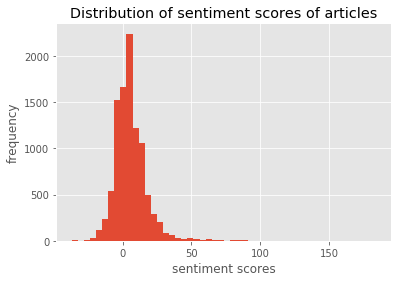

In [4]:
motley = pd.read_csv('mfool.csv')

negative = pd.read_csv('negative-words.txt', sep = ' ', header = None)
positive = pd.read_csv('positive-words.txt', sep=' ', header=None)

def score_word(word):
    """
    returns -1 if negative meaning, +1 if positive meaning,
    else 0
    
    input: a word
    ouput: -1, 0, or + 1
    """
    if word.lower() in negative.values:
        return -1
    elif word.lower() in positive.values:
        return +1
    return 0

def get_scores(article):
    """
    returns sentiment scores for a given article
    
    input: an article
    output: sentiment score
    """
    wordsArticle = article.split(' ')
    scores = [score_word(word) for word in wordsArticle]
    return sum(scores)

motley['sentiment'] = motley['article'].apply(get_scores)

plt.hist(motley.sentiment, bins=50)
plt.xlabel('sentiment scores')
plt.ylabel('frequency')
plt.title('Distribution of sentiment scores of articles');

# motley.to_csv('motley_with_s_scores.csv', encoding='utf-8')

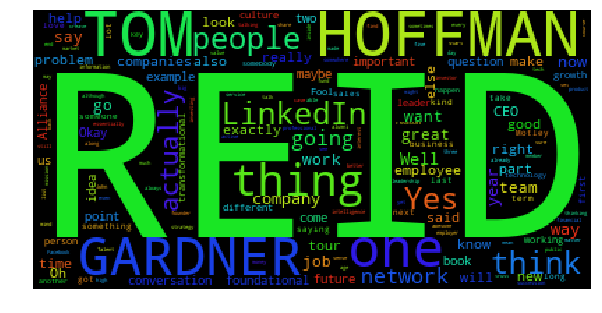

In [30]:
most_positive_article = motley['article'][motley['sentiment'] == np.max(motley['sentiment'])].values[0]
wc = WordCloud().generate(most_positive_article)
plt.imshow(wc)
plt.axis('off');

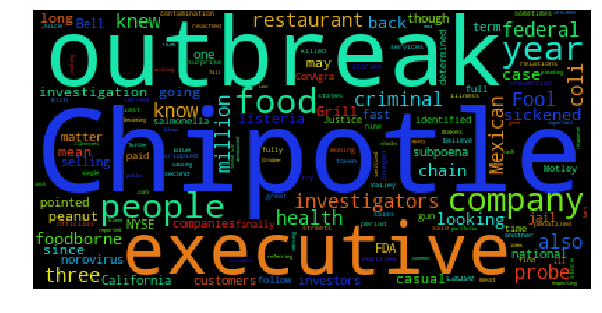

In [31]:
most_negative_article = motley['article'][motley['sentiment'] == np.min(motley['sentiment'])].values[0]
wc = WordCloud().generate(most_negative_article)
plt.imshow(wc)
plt.axis('off');

3.
merging data sets

APPLE stock data was obtained using **[Quandl](https://www.quandl.com)** API at "https://www.quandl.com/api/v3/datasets/WIKI/AAPL.csv"

In [2]:
path = "../datasets/"
aapl = pd.read_csv(path+'WIKI_PRICES_AAPL.csv')
fool = pd.read_csv(path+'motley_with_s_scores.csv')

In [20]:
def format_df(stock_df, news_df, word):
    """
    merges stock_df and news_df on "date"
    column
    
    input: stock df, news df, word
    output: merged df
    """
    
    stock_df['diff'] = stock_df['close']-stock_df['open']
    news_df['Count'] = news_df['article'].apply(lambda x: x.count(word))
    news_df.loc[news_df['Count'] <= 5, 'sentiment'] = 0
    news_df['date'] = pd.to_datetime(news_df['date'])
    news_df['date'] = news_df['date'].dt.strftime('%Y-%m-%d')
    news_df = news_df.groupby(['date'], as_index = False).sum()
    news_df = news_df[['date', 'sentiment', 'Count']]
    merged_df = pd.merge(news_df, stock_df)
    merged_df['bin_sentiment'] = pd.cut(merged_df['sentiment'], [-np.inf, -0.001, 0.001, np.inf], labels = [-1, 0, 1])
    merged_df['bin_diff'] = pd.cut(merged_df['diff'], [-np.inf, -0.001, 0.001, np.inf], labels = [-1, 0, 1])
    return merged_df

In [ ]:
merged_df = format_df(aapl, fool, 'Apple')
merged_df.head()
#merged_df.to_csv('merged_df.csv', encoding='utf-8')

# Method Selection and Model Evaluation

This problem lends itself to learning algorithms such as SVMs, logistic regression, and random forest classification trees. However, the difficulty with stock price prediction is that the observations are highly dependent to each other. Therefore, even a little knowledge whether about the outcome stock behaviour might give an edge in investement.

Due to high correlation between stock prices of each day, generic learning algorithms usually perform very poorly on this type of problems and therefore we sought to use Deep Learning methods too. Particularly, we used basic 2-layer feedword neural network and recurrent neural networks with tensorflow.

The reason behind using recurrent neural networks (RNNs) is that they have loops. These loops allow the network to use information from previous passes, which acts as memory and can store the dependency relationship between past and present time.

<img src = "https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_6/recurrent.jpg">

**Note** SVMs and logistic regression were optimized using penalty, random forest with out-of-bad errors, and neural nets with cross validation

In [3]:
def plot_ROC(y_test, scores, label, color):
    """
    plots ROC curve
    input: y_test, scores, and title
    output: ROC curve
    """
    false_pr, true_pr, _ = roc_curve(y_test, scores[:, 1])
    roc_auc = auc(false_pr, true_pr)
    plt.plot(false_pr, true_pr, lw = 3,
             label='{}: area={:10.4f})'.format(label, roc_auc), color = color)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc="best")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC')

def plot_PR(y_test, scores, label, color):
    """
    plots PR curve
    input: y_test, scores, title
    output: Precision-Recall curve
    """
    precision, recall, _ = precision_recall_curve(y_test, scores[:, 1])
    plt.plot(recall, precision,lw = 2,
             label='{}'.format(label), color = color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.legend(loc="best")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR')
    
def plot_confusionmatrix(ytrue, ypred):
    """
    
    plots confusion matrix heatmap and prints out
    classification report
    
    input: ytrue (actual value), ypred(predicted value)
    output: confusion matrix heatmap and classification report
    
    """
    
    print (classification_report(ytrue, ypred))
    
    print ('##################################################################')
    
    cnf_matrix = confusion_matrix(ytrue, ypred)
    sns.heatmap(cnf_matrix, cmap='coolwarm_r', annot = True, linewidths=.5, fmt = '.4g')
    plt.title('Confusion matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Actual');

In [4]:
apple = pd.read_csv(path + 'merged_df.csv')
apple.head()
print (apple.shape)

(779, 20)


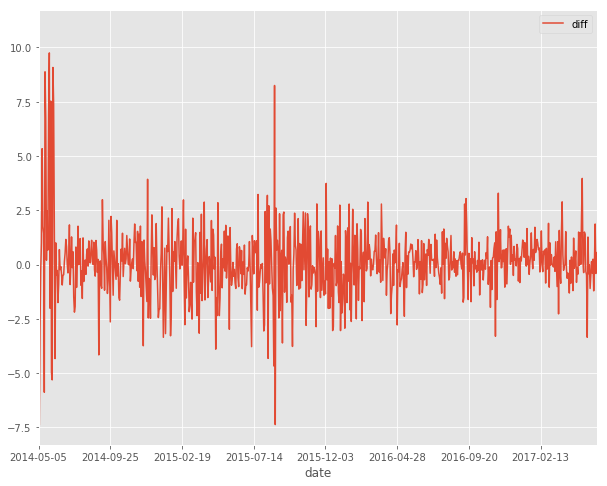

In [32]:
apple.plot('date', 'diff');

There is exterme fluctuation betweeen opening and closing prices of **Apple, Inc.** (as expected).

Let's choose the features and label (bin_diff) and make the dataframe ready for machine learning and deep learning.

In [5]:
aapl = apple.copy()[['date', 'sentiment', 'bin_diff']]
aapl.head()

,date,sentiment,bin_diff
0,2014-05-05,53,1
1,2014-05-06,15,-1
2,2014-05-07,40,-1
3,2014-05-08,31,-1
4,2014-05-09,3,1


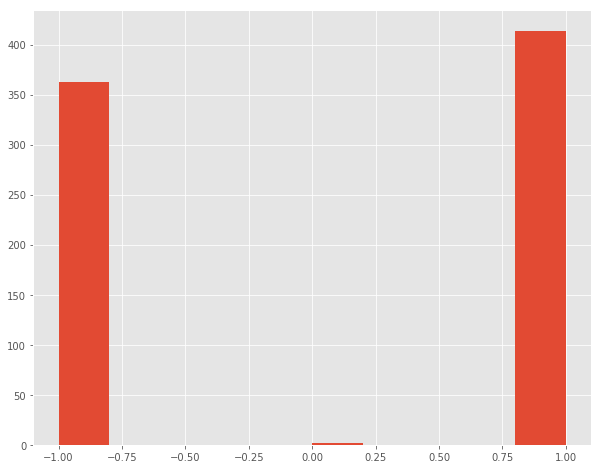

In [63]:
plt.hist(aapl['bin_diff']);

Let's drop the observation with "0" and make it binary classification.

In [6]:
aapl = aapl[aapl['bin_diff'] != 0]

Also, to make the models work properly, from now on, we **re-code** *loss* category from -1 to 0.

In [7]:
label = aapl['bin_diff'] == 1
label = label.astype(int)

let's look at the features and standardize them.

In [8]:
InputDF = aapl.copy().drop('bin_diff', axis = 1)
InputDF = InputDF.set_index('date')

In [9]:
InputDF.head()

,sentiment
date,
2014-05-05,53
2014-05-06,15
2014-05-07,40
2014-05-08,31
2014-05-09,3


In [10]:
InputDF = InputDF.apply(lambda x:(x -x.mean())/x.std())

In [11]:
InputDF.head()

,sentiment
date,
2014-05-05,0.692653
2014-05-06,-0.497135
2014-05-07,0.285620
2014-05-08,0.003828
2014-05-09,-0.872857


In [12]:
test_size = 600
xtrain, xtest = InputDF.iloc[:test_size, :], InputDF.iloc[test_size:, :]
ytrain, ytest = label[:test_size], label[test_size:]

# Results

As expected, SVMs, logistic regression, and random forest classifiers have worse/equal to performance than a coin flip based on ROC area calculated for the hold-out test set. The feed forward neural network has a slighly better performance with 0.53 ROC area while the RNN has the highest area of 0.56.

| Method | ROC area    |
| ------ | ----------- |
| Logistic Regression |  0.4373|
| SVM   | 0.4430|
| Random Forets Classifier  | 0.4735|
| Feed forward neural network | 0.5323|
| Random Forets Classifier   | 0.5557 |

The PR curves also look reasonable only for neural nets.

## Logistic regression

Accuracy score is 0.4971751412429379 for penalty = 0.001
Accuracy score is 0.4971751412429379 for penalty = 1
Accuracy score is 0.4971751412429379 for penalty = 100

confusion matrix for penalty = 100
             precision    recall  f1-score   support

          0       0.27      0.11      0.15        75
          1       0.54      0.78      0.64       102

avg / total       0.43      0.50      0.43       177

##################################################################


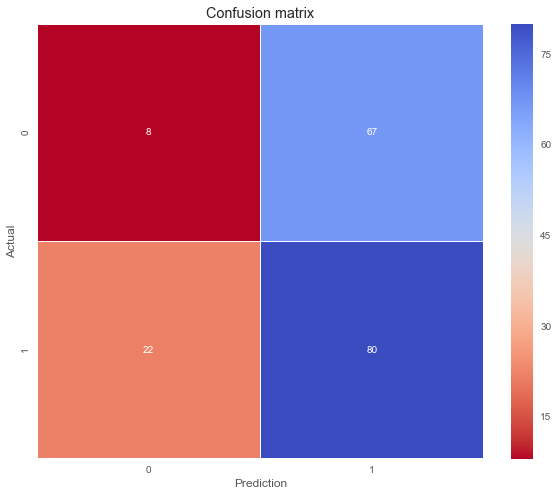

In [22]:
for pen in [1e-3, 1, 100]:
    logreg = LogisticRegression()
    logreg_model = logreg.fit(xtrain, ytrain)
    logpred = logreg_model.predict(xtest)
    logscores = logreg_model.predict_proba(xtest)
    print ("Accuracy score is {} for penalty = {}".format(accuracy_score(ytest, logpred), pen))
print ()
print ("confusion matrix for penalty = {}".format(pen))
plot_confusionmatrix(ytest, logpred)

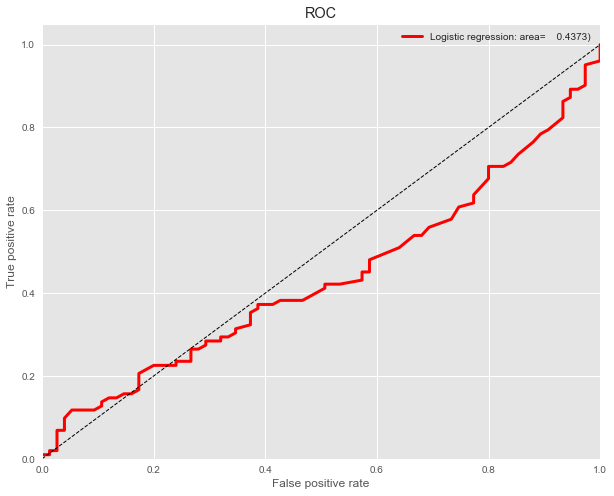

In [79]:
plot_ROC(ytest, logscores, 'Logistic regression', 'r')

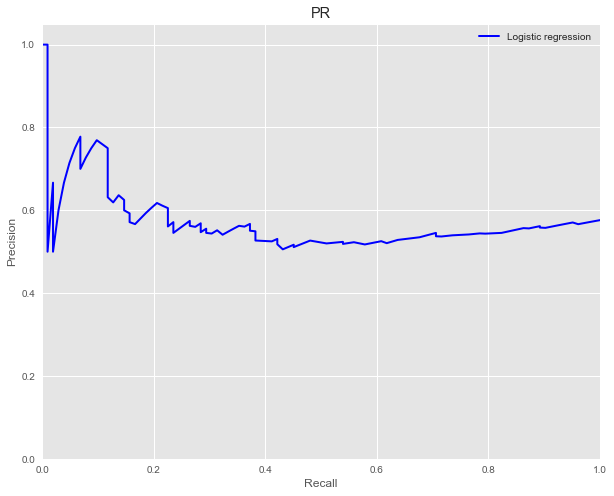

In [80]:
plot_PR(ytest, logscores, 'Logistic regression', 'b')

## Support Vector Machines

Accuracy score is 0.576271186440678 for penalty = 0.001
Accuracy score is 0.5988700564971752 for penalty = 1
Accuracy score is 0.5875706214689266 for penalty = 100

confusion matrix for penalty = 1
             precision    recall  f1-score   support

          0       0.54      0.33      0.41        75
          1       0.62      0.79      0.70       102

avg / total       0.59      0.60      0.58       177

##################################################################


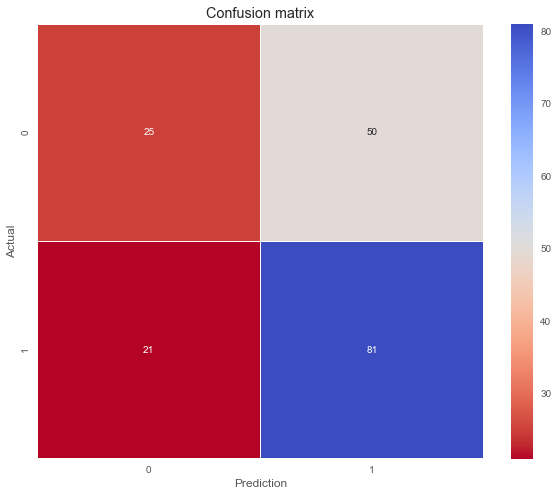

In [26]:
for pen in [1e-3, 1, 100]:
    svm = SVC(probability=True, C = pen)
    svm_model = svm.fit(xtrain, ytrain)
    svmpred = svm_model.predict(xtest)
    svmscores = svm_model.predict_proba(xtest)
    print ("Accuracy score is {} for penalty = {}".format(accuracy_score(ytest, svmpred), pen))
print ()
pen = 1
svm = SVC(probability=True, C = pen)
svm_model = svm.fit(xtrain, ytrain)
svmpred = svm_model.predict(xtest)
svmscores = svm_model.predict_proba(xtest)
print ("confusion matrix for penalty = {}".format(pen))
plot_confusionmatrix(ytest, svmpred)

ROC curve for penalty = 1


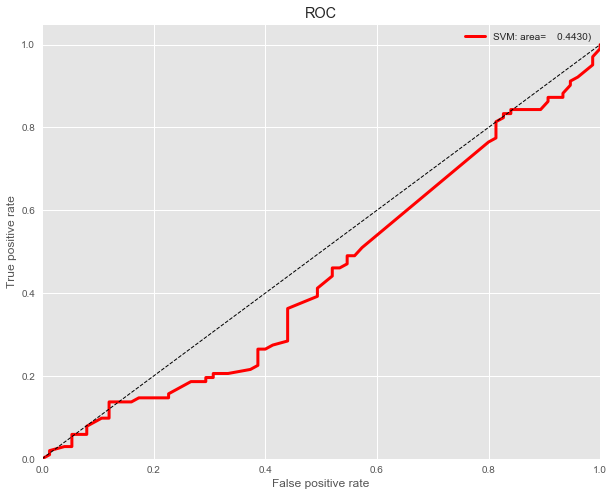

In [27]:
print ("ROC curve for penalty = {}".format(pen))
plot_ROC(ytest, svmscores, 'SVM', 'r')

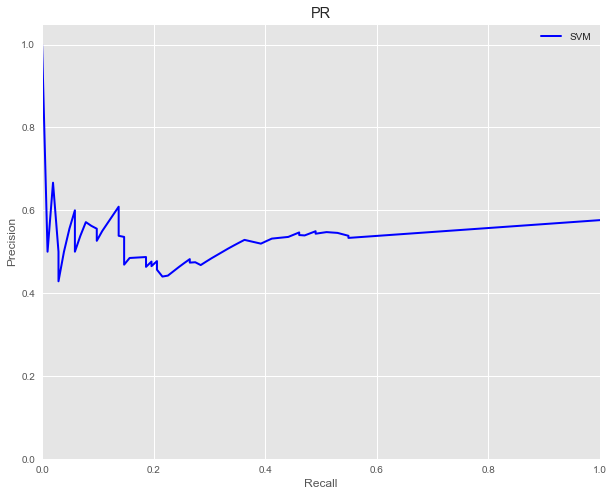

In [86]:
plot_PR(ytest, svmscores, 'SVM', 'b')

## Random Forest Tree Classifiers

/Users/admin/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


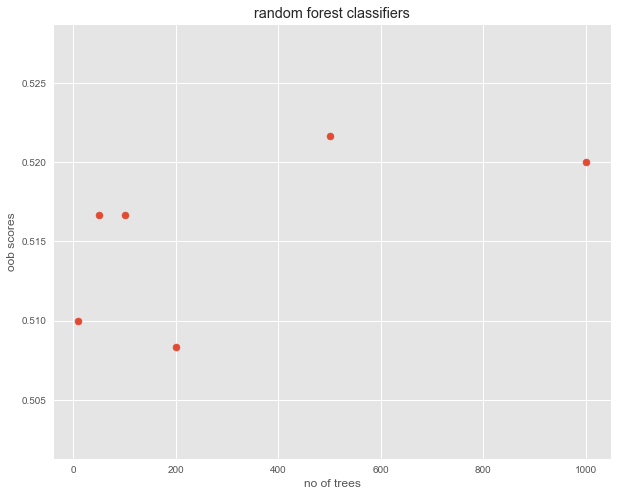

In [34]:
oobscores = []
notrees = [10, 50, 100, 200, 500, 1000]
for n in notrees:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rf_model = rf.fit(xtrain, ytrain)
    oobscores.append(rf_model.oob_score_)

plt.scatter(notrees, oobscores)
plt.xlabel('no of trees')
plt.ylabel('oob scores')
plt.title('random forest classifiers');

Fit random forest with 500 trees

             precision    recall  f1-score   support

          0       0.36      0.39      0.37        75
          1       0.53      0.50      0.51       102

avg / total       0.46      0.45      0.45       177

##################################################################


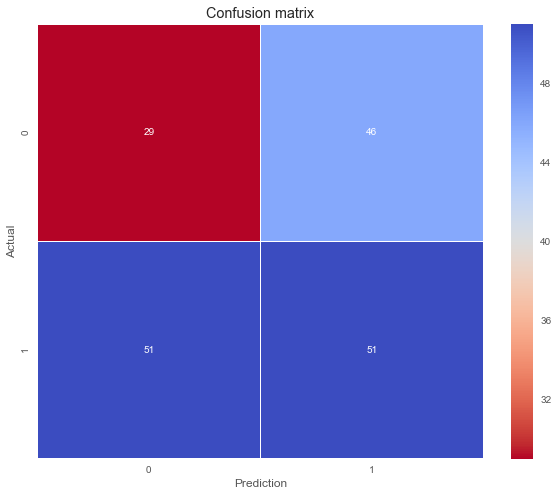

In [36]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
rf_model = rf.fit(xtrain, ytrain)
rfpred = rf.predict(xtest)
rfscores = rf.predict_proba(xtest)
plot_confusionmatrix(ytest, rfpred)

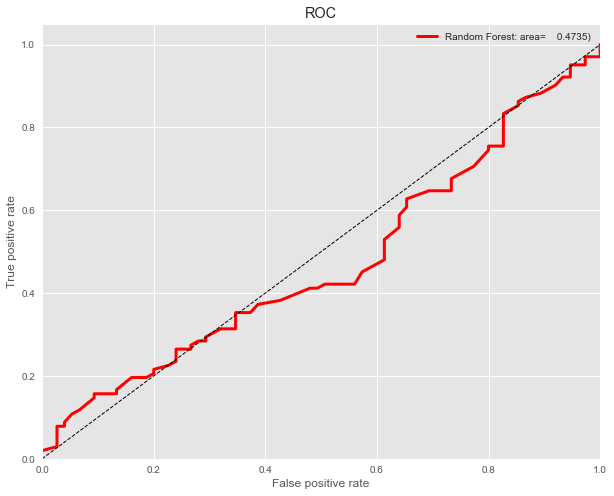

In [37]:
plot_ROC(ytest, rfscores, 'Random Forest', 'r')

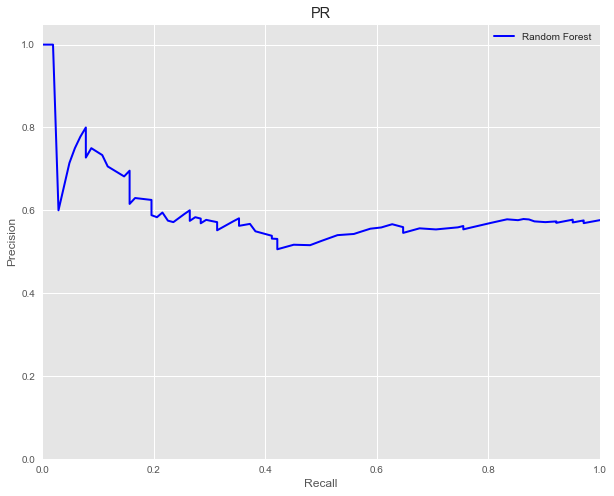

In [38]:
plot_PR(ytest, rfscores, 'Random Forest', 'b')

## Feed Forward Neural Network

In [90]:
num_features = len(InputDF.columns)
dropout=0.2
hidden_1_size = 25
hidden_2_size = 5
num_classes = label.nunique()
NUM_EPOCHS=20
BATCH_SIZE=1
lr=0.0001
np.random.RandomState(52);

In [91]:
val = (InputDF[:-test_size].values, label[:-test_size].values)
train = (InputDF[-test_size:].values, label[-test_size:].values)
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)

In [92]:
class Model():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[None,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[None])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        with tf.variable_scope("ff"):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_1_size,
                inputs=droped_input,
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_2_size,
                inputs=layer_1,
            )
            self.logits = tf.contrib.layers.fully_connected(
                num_outputs=num_classes,
                activation_fn =None,
                inputs=layer_2,
            )
        with tf.variable_scope("loss"):
            
            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                         labels = self.target_data)
            mask = (1-tf.sign(1-self.target_data)) #Don't give credit for flat days
            mask = tf.cast(mask,tf.float32)
            self.loss = tf.reduce_sum(self.losses)
        
        with tf.name_scope("train"):
            opt = tf.train.AdamOptimizer(lr)
            gvs = opt.compute_gradients(self.loss)
            self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            self.probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(self.probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

In [110]:
with tf.Graph().as_default():
    model = Model()
    input_ = train[0]
    target = train[1]
    losses = []
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run([init])
        epoch_loss =0
        for e in range(NUM_EPOCHS):
            if epoch_loss >0 and epoch_loss <1:
                break
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.9
                            }
                
                _,loss,acc = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
            losses.append(epoch_loss)
            #print('step - {0} loss - {1} acc - {2}'.format((1+batch+NUM_TRAIN_BATCHES*e),epoch_loss,acc))
                
        
        print('################ done training ################')
        final_preds =np.array([])
        final_scores =None
        for batch in range(0,NUM_VAL_BATCHES):
            
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1
                            }
                
                acc,preds,probs = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.probs
                    ]
                    ,feed_dict=feed
                )
                #print(acc)
                final_preds = np.concatenate((final_preds,preds),axis=0)
                if final_scores is None:
                    final_scores = probs
                else:
                    final_scores = np.concatenate((final_scores,probs),axis=0)
        print ('################ done testing ################')
        prediction_conf = final_scores[np.argmax(final_scores, 1)]

Instructions for updating:
Use `tf.global_variables_initializer` instead.
################ done training ################
################ done testing ################


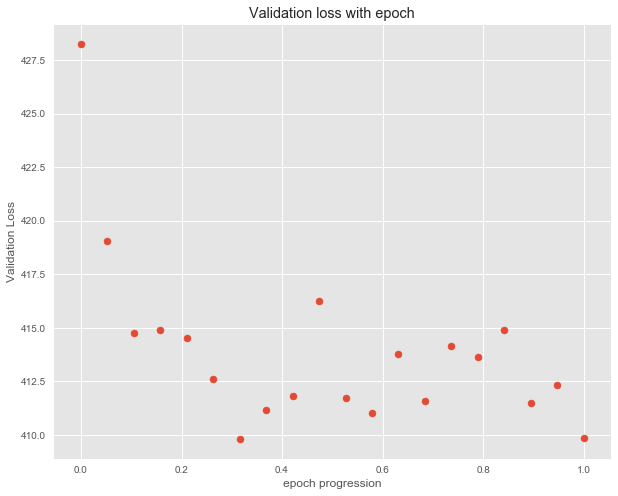

In [94]:
plt.scatter(np.linspace(0, 1, len(losses)), losses);
plt.title('Validation loss with epoch')
plt.ylabel('Validation Loss')
plt.xlabel('epoch progression');

             precision    recall  f1-score   support

          0       0.44      0.37      0.40        75
          1       0.58      0.65      0.61       102

avg / total       0.52      0.53      0.52       177

##################################################################


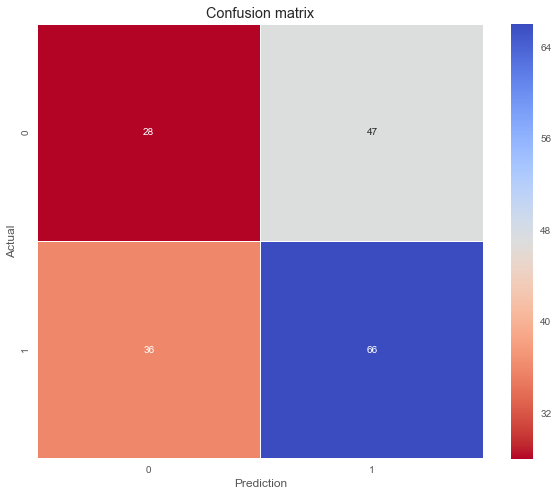

In [95]:
plot_confusionmatrix(ytest, final_preds)

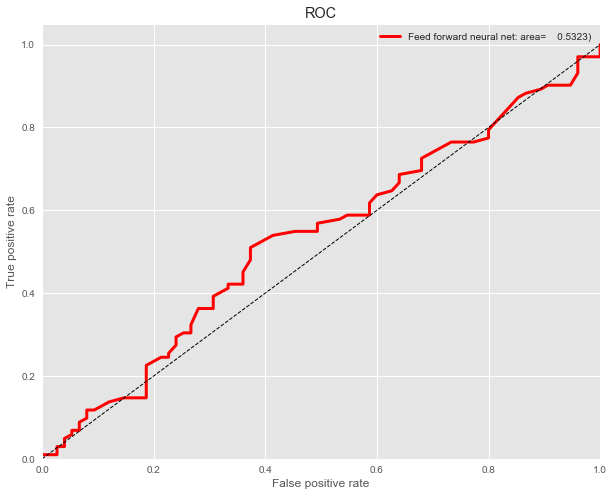

In [97]:
plot_ROC(ytest, final_scores, 'Feed forward neural net', 'r')

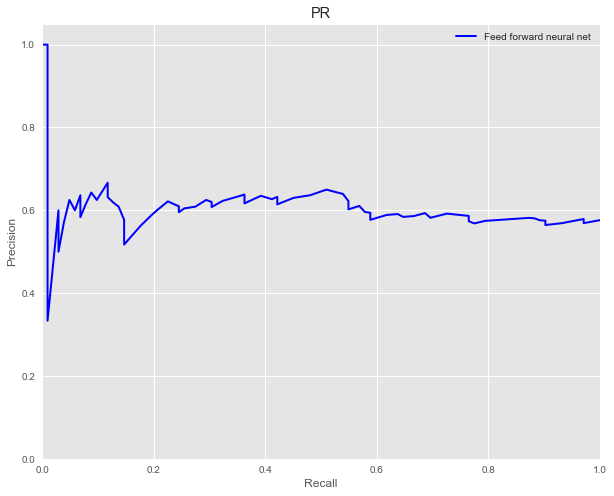

In [98]:
plot_PR(ytest, final_probs, 'Feed forward neural net', 'b')

# Recursive Neural Nets

In [99]:
RNN_HIDDEN_SIZE=4
FIRST_LAYER_SIZE=50
SECOND_LAYER_SIZE=10
NUM_LAYERS=2
BATCH_SIZE=1
NUM_EPOCHS=25
lr=0.0003
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)
ATTN_LENGTH=30
beta=0
np.random.RandomState(52);

In [103]:
class RNNModel():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[BATCH_SIZE,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[BATCH_SIZE])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        
        def makeGRUCells():
            base_cell = rnn.GRUCell(num_units=RNN_HIDDEN_SIZE,) 
            layered_cell = rnn.MultiRNNCell([base_cell] * NUM_LAYERS,state_is_tuple=False) 
            attn_cell =tf.contrib.rnn.AttentionCellWrapper(cell=layered_cell,attn_length=ATTN_LENGTH,state_is_tuple=False)
            return attn_cell
        
        self.gru_cell = makeGRUCells()
        self.zero_state = self.gru_cell.zero_state(1, tf.float32)
        
        self.start_state = tf.placeholder(dtype=tf.float32,shape=[1,self.gru_cell.state_size])
        
        

        with tf.variable_scope("ff",initializer=xavier_initializer(uniform=False)):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=FIRST_LAYER_SIZE,
                inputs=droped_input,
                
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=RNN_HIDDEN_SIZE,
                inputs=layer_1,
                
            )
            
        
        split_inputs = tf.reshape(droped_input,shape=[1,BATCH_SIZE,num_features],name="reshape_l1") # Each item in the batch is a time step, iterate through them
        split_inputs = tf.unstack(split_inputs,axis=1,name="unpack_l1")
        states =[]
        outputs =[]
        with tf.variable_scope("rnn",initializer=xavier_initializer(uniform=False)) as scope:
            state = self.start_state
            for i, inp in enumerate(split_inputs):
                if i >0:
                    scope.reuse_variables()
                
                output, state = self.gru_cell(inp, state)
                states.append(state)
                outputs.append(output)
        self.end_state = states[-1]
        outputs = tf.stack(outputs,axis=1) # Pack them back into a single tensor
        outputs = tf.reshape(outputs,shape=[BATCH_SIZE,RNN_HIDDEN_SIZE])
        self.logits = tf.contrib.layers.fully_connected(
            num_outputs=num_classes,
            inputs=outputs,
            activation_fn=None
        )

            
        with tf.variable_scope("loss"):
            self.penalties =    tf.reduce_sum([beta*tf.nn.l2_loss(var) for var in tf.trainable_variables()])

            
            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.logits,
                                                                         labels = self.target_data)
            self.loss = tf.reduce_sum(self.losses + beta*self.penalties)
        
        with tf.name_scope("train_step"):
            opt = tf.train.AdamOptimizer(lr)
            gvs = opt.compute_gradients(self.loss)
            self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            self.probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(self.probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

# Training the RNN

In [105]:
with tf.Graph().as_default():
    model = RNNModel()
    input_ = train[0]
    target = train[1]
    losses = []
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run([init])
        loss = 2000
        
        for e in range(NUM_EPOCHS):
            state = sess.run(model.zero_state)
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.5,
                    model.start_state:state
                            }
                _,loss,acc,state = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                        model.end_state
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
            losses.append(epoch_loss)
            #print('step - {0} loss - {1} acc - {2}'.format((e),epoch_loss,acc))
        print('################ done training ################')
        
        final_preds =np.array([])
        final_scores = None
        for batch in range(0,NUM_VAL_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1,
                    model.start_state:state
                            }
                acc,preds,state, probs = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.end_state,
                        model.probs
                    ]
                    ,feed_dict=feed
                )
                #print(acc)
                assert len(preds) == BATCH_SIZE
                final_preds = np.concatenate((final_preds,preds),axis=0)
                if final_scores is None:
                    final_scores = probs
                else:
                    final_scores = np.concatenate((final_scores,probs),axis=0)
        print('################ done testing ################')

################ done training ################
################ done testing ################


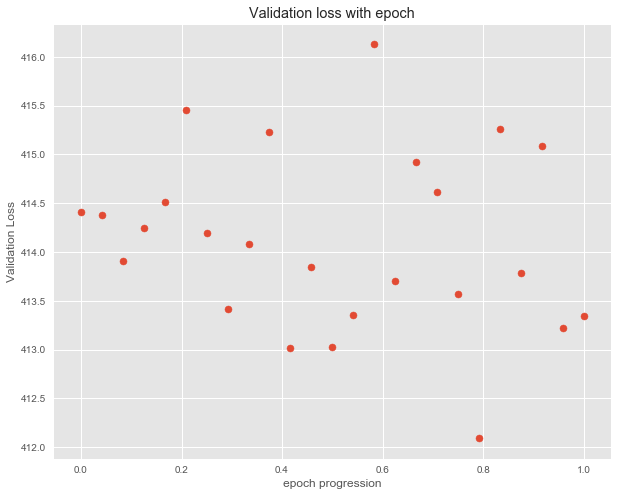

In [106]:
plt.scatter(np.linspace(0, 1, len(losses)), losses);
plt.title('Validation loss with epoch')
plt.ylabel('Validation Loss')
plt.xlabel('epoch progression');

             precision    recall  f1-score   support

          0       0.51      0.29      0.37        75
          1       0.60      0.79      0.69       102

avg / total       0.57      0.58      0.55       177

##################################################################


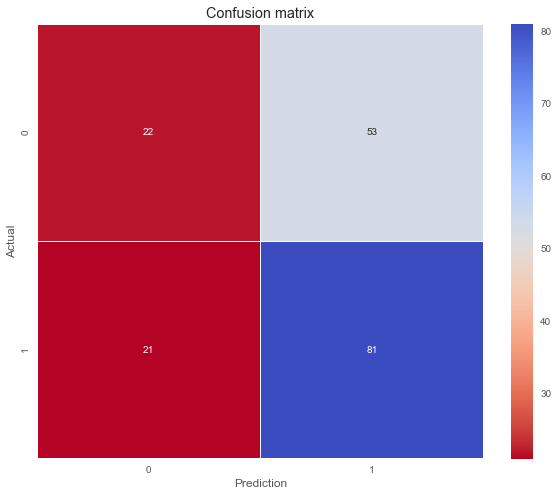

In [107]:
plot_confusionmatrix(ytest, final_preds)

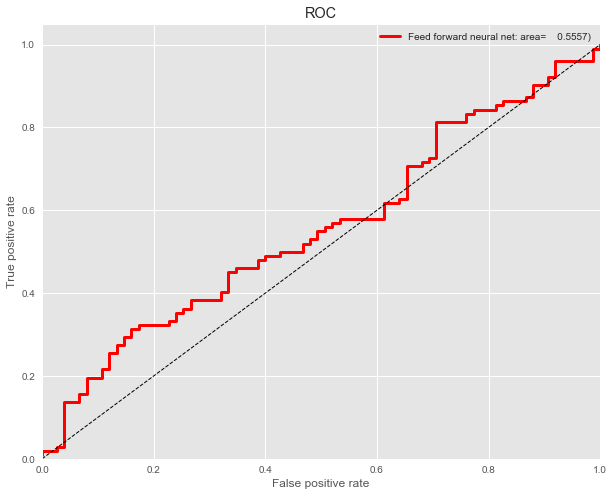

In [108]:
plot_ROC(ytest, final_scores, 'Feed forward neural net', 'r')

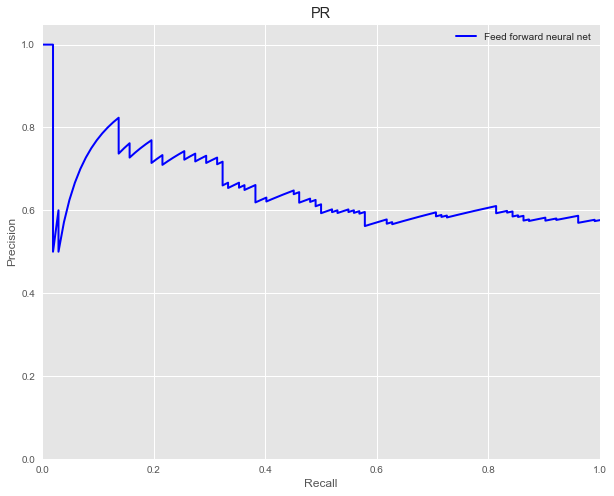

In [109]:
plot_PR(ytest, final_scores, 'Feed forward neural net', 'b')

# Conclusion

Although, the neural nets do not have extremely better performance than a coin flip, they can definitely give an edge during decision of investement in Apple, Inc stockes. The classical supervised machine learning classification methods perform even worse than a random guess. In this sense, the performance of deep learning methods, especially RNNs, are really satisfactory.

## Future work

There are definitely ways to improve the performance of deep learning approaches. First, we're not that confident whether we have used the best parameters such no layers, hidden units, etc.

Second, it makes sense to collect news articles from different sources and use aggregate sentiment scores. Articles from only one source might be biased. Moreover, we could think of using most common words as features instead of sentiment scoring.

All in all, better feature engineering might improve performance of deep learning methods.